In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from IPython.display import HTML

# Import the data

In [2]:
with open('conflict.pickle', 'rb') as src:
    events = pickle.load(src)
    
events.type_of_violence = events.type_of_violence.astype('category')
events.where_prec       = events.where_prec.astype('category')
events.type_of_violence.cat.rename_categories(['state-based', 'non-state', 'one-sided'], inplace=True)

In [3]:
events.head(2)

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,geom_wkt,country,country_id,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,4,2010,state-based,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2010,2,0,0,0,2
1,5,2011,one-sided,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,POINT (45.036667 12.779444),Yemen (North Yemen),678,2011,2011,0,0,0,0,0


# Combining events into conflicts

The fundental unit of the dataset is the event. However we are interested in conflicts. Therefore we group events into conflicts and aggregate some of the features:

- `date_start` and `date_end` are combined to obtain a length for each event that will be summed across all events.
- `date_start` becomes the oldest date in the list of start dates of the events in a conflict.
- `date_end` similarly becomes the most recent
- all the deaths counts are summed.
- A list of all sides, countries and coordinates is kept for each conflict

In [4]:
format = '%Y-%m-%d'
events['date_start'] = pd.to_datetime(events.date_start, format=format)
events['date_end'] = pd.to_datetime(events.date_end, format=format)
events['duration'] = events.date_end - events.date_start

In [5]:
conflicts = events.groupby('conflict_new_id').agg({
    'duration': 'sum',
    'date_start': 'min',
    'date_end': 'max',
    'deaths_civilians': 'sum',
    'deaths_unknown': 'sum',
    'best': 'sum',
    'latitude': lambda x: list(x),
    'longitude': lambda x: list(x),
    'country': lambda x: set(x),
    'side_a': lambda x: list(x),
    'side_b': lambda x: list(x)
})

In [6]:
names = events[['conflict_new_id', 'conflict_name']].drop_duplicates()\
                                                    .set_index('conflict_new_id').conflict_name

In [7]:
conflicts['name'] = names

In [8]:
conflicts = conflicts.rename(columns={
    'country': 'countries',
    'side_a': 'sides_a',
    'side_b': 'sides_b',
    'latitude': 'latitudes',
    'longitude': 'longitudes'
})

In [9]:
conflicts.head()

,duration,date_start,date_end,deaths_civilians,deaths_unknown,best,latitudes,longitudes,countries,sides_a,sides_b,name
conflict_new_id,,,,,,,,,,,,
205,0 days,1990-01-01,2016-01-01,92,56,218,"[36.246389, 36.155278, 37.32322, 35.73671, 36....","[46.266389, 45.478889, 48.041134, 46.274843, 4...","{Iraq, Iran, Germany, Turkey}","[Government of Iran, Government of Iran, Gover...","[KDPI, KDPI, KDPI, KDPI, KDPI, KDPI, KDPI, KDP...",Iran:Kurdistan
209,0 days,1989-01-01,2016-01-01,276,221,7786,"[12.782008, 7.780424, 12.75, 8.895, 12.4863, 1...","[123.952024, 123.292649, 124.033333, 125.77527...",{Philippines},"[Government of Philippines, Government of Phil...","[CPP, CPP, CPP, CPP, CPP, CPP, CPP, CPP, CPP, ...",Philippines:Government
218,0 days,1989-01-01,2016-01-01,187,331,1701,"[34.57173, 34.683056, 34.484389, 33.831266, 34...","[73.89724, 76.645, 75.658389, 74.046931, 73.85...","{Pakistan, India}","[Government of India, Government of India, Gov...","[Government of Pakistan, Government of Pakista...",Government of India-Government of Pakistan
220,0 days,1989-01-01,1989-01-01,0,150,150,[-25.29389],[-57.611111],{Paraguay},[Government of Paraguay],[Military faction (forces of Andres Rodriguez)],Paraguay:Government
221,0 days,1989-01-01,2015-01-01,196,1366,4550,"[17.5, 17.5, 17.5, 17.5, 17.5, 17.5, 22.0, 17....","[97.75, 97.75, 97.75, 97.75, 97.75, 97.75, 98....","{Thailand, Myanmar (Burma)}","[Government of Myanmar (Burma), Government of ...","[KNU, KNU, KNU, KNU, KNU, DKBA 5, KNU, KNU, KN...",Myanmar (Burma):Karen


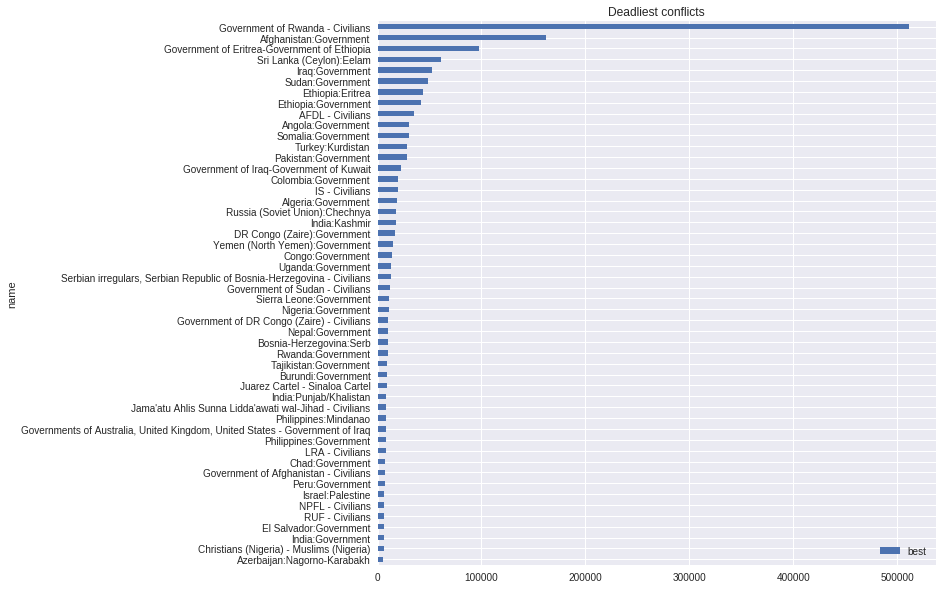

In [43]:
conflicts[['name', 'best']].sort_values(by='best')[-50:].set_index('name')\
                           .plot(kind='barh', figsize=(10,10), title='Deadliest conflicts')

# Analyzing factions (sides)

## Create the dataframe with one record per (side_a, side_b)

In [10]:
sides_a = events[['side_a_new_id', 'side_a']]
sides_a.columns = ['id', 'name']
sides_a = sides_a.set_index('id')

sides_b = events[['side_b_new_id', 'side_b']]
sides_b.columns = ['id', 'name']
sides_b = sides_b.set_index('id')

sides = pd.concat([sides_a, sides_b]).drop_duplicates()

print('The total number of sides is {}'.format(len(sides)))

The total number of sides is 1143


In [11]:
# Aggregate data
sides_victims = events.groupby(['side_a_new_id', 'side_b_new_id']).best.sum()
sum_victims_a = events.groupby(['side_a_new_id', 'side_b_new_id']).deaths_a.sum()
sum_victims_b = events.groupby(['side_a_new_id', 'side_b_new_id']).deaths_b.sum()

# Build new dataframe
sides_victims = pd.DataFrame({
    'dead': sides_victims,
    'dead_a': sum_victims_a,
    'dead_b': sum_victims_b
}).reset_index()

# Merge to have side names
sides_victims = sides_victims.merge(sides, left_on='side_a_new_id', right_index=True)
sides_victims = sides_victims.merge(sides, left_on='side_b_new_id', right_index=True)

# Rename columns and sort
sides_victims.columns = ['id_a', 'id_b', 'dead', 'dead_a', 'dead_b', 'name_a', 'name_b']
sides_victims.sort_values(by='dead', inplace=True, ascending=False)

In [12]:
sides_victims.to_json('sides.json', orient='records') # Export to json to build visualizations

In [13]:
sides_victims.head()

,id_a,id_b,dead,dead_a,dead_b,name_a,name_b
184,94,1,511531,0,0,Government of Rwanda,Civilians
312,130,303,107344,23596,67146,Government of Afghanistan,Taleban
210,98,97,97435,13817,5140,Government of Eritrea,Government of Ethiopia
387,145,320,60697,14462,37568,Government of Sri Lanka,LTTE
271,116,234,47859,9487,25570,Government of Iraq,IS


In [14]:
sides_victims[(sides_victims.dead_a + sides_victims.dead_b) == (sides_victims.dead)].head()

,id_a,id_b,dead,dead_a,dead_b,name_a,name_b
552,466,1037,390,140,250,SPLM/A,SSUM/A
636,591,3807,384,3,381,Borana,"Gabra, Garre"
855,917,591,319,19,300,Arbore,Borana
755,709,710,280,152,128,Bi'idyahan subclan of Majerteen clan (Darod),Ismail subclan of Makahil clan (Darod)
649,601,688,227,210,17,Dizi,Suri


## Create a network of sides

In [15]:
sides_net = nx.from_pandas_dataframe(sides_victims[:100], source='name_a', target='name_b', edge_attr='dead')

/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


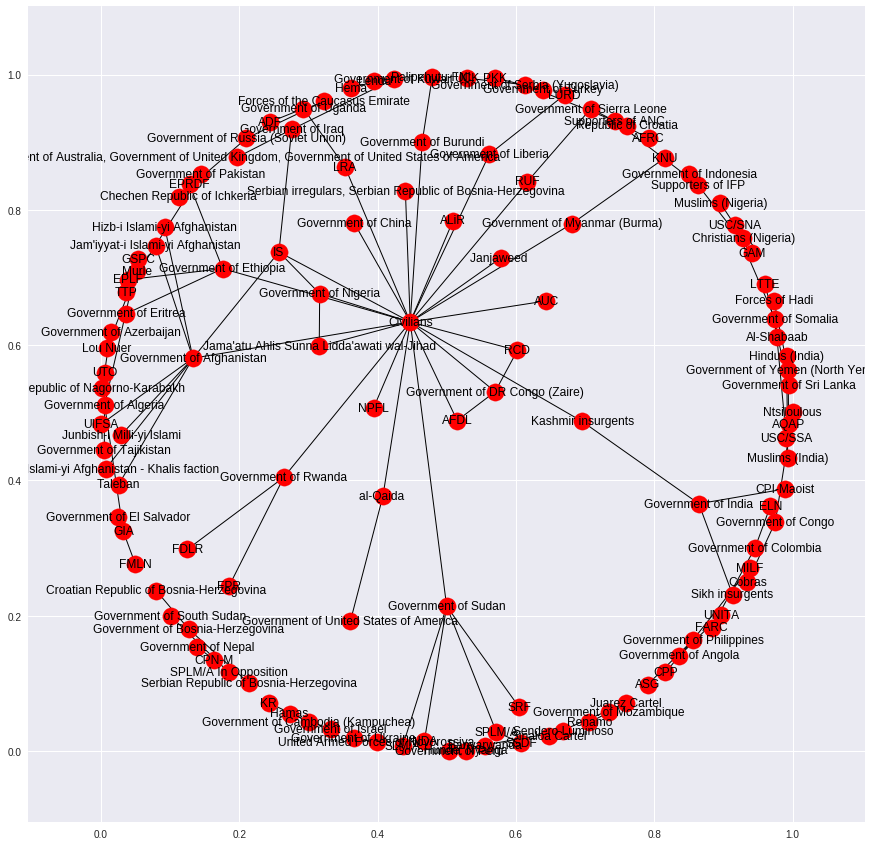

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(sides_net, ax=ax)

In [17]:
faction, degree = zip(*map(tuple, sides_net.degree().items()))

In [18]:
def degree_distribution(degrees):
    c = Counter()
    for deg in degrees:
        c[deg] += 1
    return c

In [19]:
degree, count = zip(*sorted(degree_distribution(degree).items(), key=lambda k: k[0]))

Text(0,0.5,'Factions with that number of rivals')

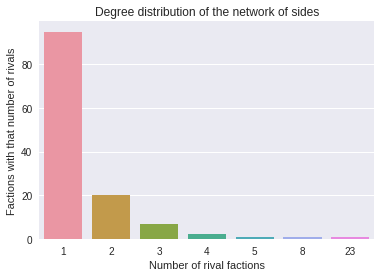

In [20]:
ax = sns.barplot(degree, count)
ax.set_title('Degree distribution of the network of sides')
ax.set_xlabel('Number of rival factions')
ax.set_ylabel('Factions with that number of rivals')

We see that most of the faction only fought against one opponent. There is no "big villain" who tries to conquer the world.
As most of the nodes have degree 1, it is not really a graph.

As we characterized each edge with the number of dead people for that pair of sides, we can visualize this as a flow using a sankey diagram. The color and width of the edges varies from blue to red proportionally to the number of victims.
Here is the graph for the top 20 most deadly rivalities

![sankey](sankey.svg)

In addition that, when we have enough precision in the data such that the $victims_{a} + victims_{b} = total$ we can use a chord diagram to visualize, for the nodes with degree bigger than one, the proportion of victims caused by each enemy:

![chord](chord.png)